In [1]:
from pyspark.sql import SparkSession 
spark = SparkSession.builder.appName("Spark_Project").config("spark.sql.shuffle.partitions", "8").config("spark.executor.memory", "8g").getOrCreate()

df = spark.read.csv('data/DataCoSupplyChainDataset.csv',header=True,inferSchema=True , encoding="ISO-8859-1")

In [2]:
df.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

In [3]:
df.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

In [4]:
df = df.filter(df["Order Status"] != "CANCELED")


In [5]:
df.describe().show()

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+------------------+------------------+------------------+-------------+----------------+--------------+--------------+-----------------+--------------+-----------------+----------------+------------------+---------------+-----------------+------------------+---------------+------------------+------------------+------+--------------+-------------+-----------------+-----------------------+------------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+--------------+--------------+---------------+-----------------+-----------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------+--------------------------+--------------+
|summa

In [6]:
from pyspark.sql.functions import col

count = df.filter(col("Order Customer Id") == col("Customer Id")).count()
total = df.count()
print(f"Matching: {count} out of {total}")


Matching: 176827 out of 176827


In [7]:
cols_to_keep = [
    'Type',
    'Days for shipment (scheduled)',
    'Late_delivery_risk',
    'Category Id',
    'Latitude',
    'Longitude',
    'Order Country',
    'Order City',
    'shipping date (DateOrders)',
    'Shipping Mode',
]


df = df.select(cols_to_keep)


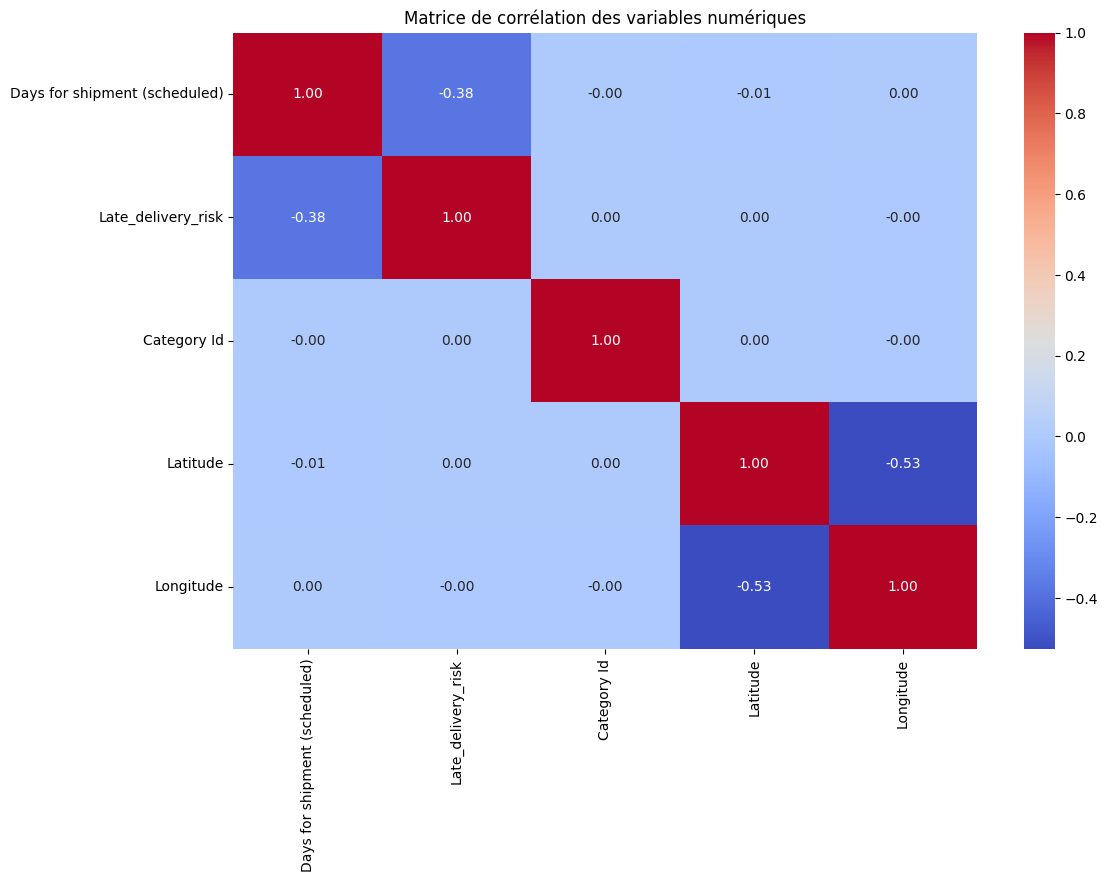

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


numeric_cols = [c for c, t in df.dtypes if t in ('int', 'double', 'float')]

pdf = df.select(numeric_cols).toPandas()

corr = pdf.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques")
plt.show()


In [9]:
from pyspark.sql.functions import sum

missing_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

missing_counts_filtered = missing_counts.select(
    [c for c in missing_counts.columns if missing_counts.first()[c] > 0]
)

missing_counts_filtered.show()

++
||
++
||
++



In [10]:
df = df.dropDuplicates()


IQR = 2.0, Thresholds: [-1.0, 7.0]
Nombre d'outliers for column Days for shipment (scheduled): 0


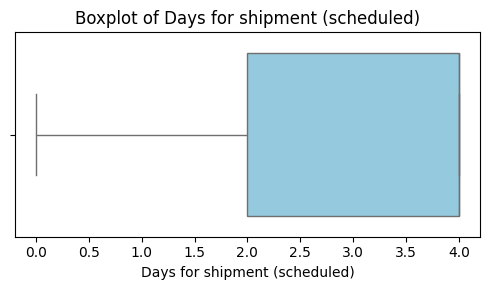

##################################################
IQR = 1.0, Thresholds: [-1.5, 2.5]
Nombre d'outliers for column Late_delivery_risk: 0


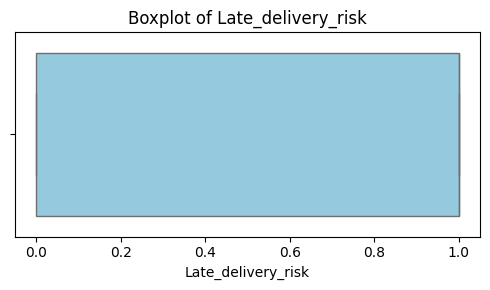

##################################################
IQR = 27.0, Thresholds: [-22.5, 85.5]
Nombre d'outliers for column Category Id: 0


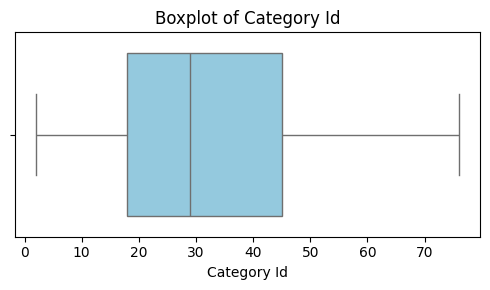

##################################################
IQR = 19.850833889999997, Thresholds: [-11.508466714999994, 67.89486884499999]
Nombre d'outliers for column Latitude: 9


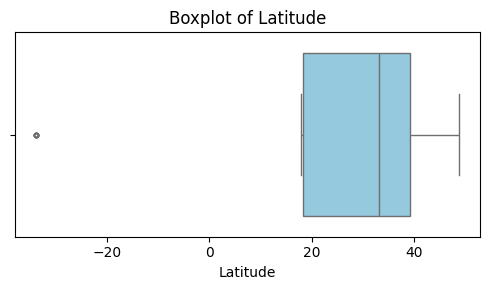

##################################################
IQR = 31.279174799999993, Thresholds: [-144.56853483999998, -19.451835640000013]
Nombre d'outliers for column Longitude: 1218


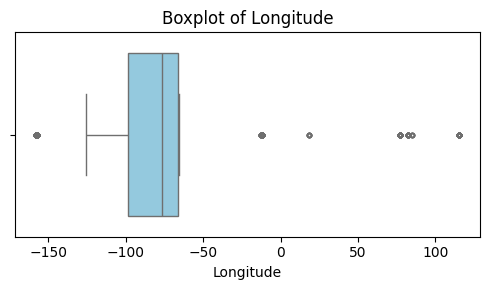

##################################################


In [11]:
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType
import matplotlib.pyplot as plt
import seaborn as sns


for c in df.columns:
    if not isinstance(df.schema[c].dataType, NumericType):
        continue

    quantiles = df.approxQuantile(c, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"IQR = {IQR}, Thresholds: [{lower_bound}, {upper_bound}]")

    outliers = df.filter((col(c) < lower_bound) | (col(c) > upper_bound))
    outlier_count = outliers.count()
    print(f"Nombre d'outliers for column {c}: {outlier_count}")
  
    sample_pd = df.select(c).toPandas()

    plt.figure(figsize=(5, 3))
    sns.boxplot(x=sample_pd[c], color="skyblue", fliersize=3)
    plt.title(f"Boxplot of {c}")
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

    print('#' * 50)

In [12]:
df.show(10)

+--------+-----------------------------+------------------+-----------+-----------+------------+--------------+-------------+--------------------------+--------------+
|    Type|Days for shipment (scheduled)|Late_delivery_risk|Category Id|   Latitude|   Longitude| Order Country|   Order City|shipping date (DateOrders)| Shipping Mode|
+--------+-----------------------------+------------------+-----------+-----------+------------+--------------+-------------+--------------------------+--------------+
|TRANSFER|                            2|                 1|         73| 36.6763382| -121.656517|     Indonesia|       Manado|            1/17/2018 8:36|  Second Class|
|TRANSFER|                            4|                 1|         73|18.26469612|-66.03705597|         India|    Bangalore|           1/18/2018 21:02|Standard Class|
| PAYMENT|                            2|                 1|         17|18.38011932|-66.18312836|         India|     Mirzapur|           2/29/2016 13:57|  Second

In [13]:
from pyspark.sql.functions import to_timestamp ,month

df = df.withColumn("shipping_datetime", to_timestamp("shipping date (DateOrders)", "M/d/yyyy H:mm"))

df = df.withColumn("shipping_month", month("shipping_datetime"))
df = df.drop("shipping date (DateOrders)","shipping_datetime")


In [14]:
df.show(20)


+--------+-----------------------------+------------------+-----------+-----------+------------+--------------+-------------+--------------+--------------+
|    Type|Days for shipment (scheduled)|Late_delivery_risk|Category Id|   Latitude|   Longitude| Order Country|   Order City| Shipping Mode|shipping_month|
+--------+-----------------------------+------------------+-----------+-----------+------------+--------------+-------------+--------------+--------------+
|TRANSFER|                            2|                 1|         73| 36.6763382| -121.656517|     Indonesia|       Manado|  Second Class|             1|
|TRANSFER|                            4|                 1|         73|18.26469612|-66.03705597|         India|    Bangalore|Standard Class|             1|
| PAYMENT|                            2|                 1|         17|18.38011932|-66.18312836|         India|     Mirzapur|  Second Class|             2|
| PAYMENT|                            2|                 1|     

In [15]:
# import requests
# from requests.adapters import HTTPAdapter
# from urllib3.util.retry import Retry
# from concurrent.futures import ThreadPoolExecutor, as_completed

# # --------------------------
# # Setup a requests Session with retry logic
# # --------------------------
# def create_session():
#     session = requests.Session()
#     retries = Retry(
#         total=5,
#         backoff_factor=0.5,
#         status_forcelist=[429, 500, 502, 503, 504],
#         allowed_methods=["GET"]
#     )
#     adapter = HTTPAdapter(max_retries=retries)
#     session.mount("https://", adapter)
#     session.mount("http://", adapter)
#     return session

# session = create_session()

# API_KEY = "b36185c337a14a57ba7ce5a36e5bfffc"

# def fetch_coords(city, country):
#     try:
#         url = (
#             f"https://api.geoapify.com/v1/geocode/search"
#             f"?city={city}&country={country}&apiKey={API_KEY}"
#         )

#         response = session.get(url, timeout=10)
#         data = response.json()

#         features = data.get("features", [])
#         if features:
#             props = features[0]["properties"]
#             return city, (props.get("lat", 0), props.get("lon", 0))

#         return city, (0, 0)

#     except Exception as e:
#         print(f"Error for {city}, {country}: {e}")
#         return city, (0, 0)

# all_locations = df.select("Order City", "Order Country").distinct().collect()

# locations_list = [(row["Order City"], row["Order Country"]) for row in all_locations]

# city_coords = {}

# MAX_THREADS = 8

# with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
#     futures = [
#         executor.submit(fetch_coords, city, country)
#         for city, country in locations_list
#     ]

#     for future in as_completed(futures):
#         city, coords = future.result()
#         city_coords[city] = coords
#         print(city, coords)


# print("Finished:", len(city_coords), "coordinates fetched.")


In [16]:
# coords_list = [(str(city), float(lat), float(lon)) for city, (lat, lon) in city_coords.items()]
# coords_df = spark.createDataFrame(coords_list, ["Order City", "New_Latitude", "New_Longitude"])

# cleaned_data = df.join(coords_df, on="Order City", how="left")



In [20]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexer_type = StringIndexer(inputCol="Type", outputCol="TypeIndex")
indexer_orderCountry = StringIndexer(inputCol="Order Country", outputCol="OrderCountryIndex")
indexer_orderCity = StringIndexer(inputCol="Order City", outputCol="OrderCityIndex")
indexer_shippingMode = StringIndexer(inputCol="Shipping Mode", outputCol="ShippingModeIndex")


encoder = OneHotEncoder(
    inputCols=["TypeIndex","OrderCountryIndex", "OrderCityIndex","ShippingModeIndex"],
    outputCols=["TypeVec","OrderCountryVec", "OrderCityVec","ShippingModeVec"]
)

from pyspark.ml import Pipeline

encoding_pipeline = Pipeline(stages=[indexer_type,indexer_orderCountry, indexer_orderCity,indexer_shippingMode, encoder])
df_encoded = encoding_pipeline.fit(df).transform(df)

df_encoded = df_encoded.drop("Order Country", "Order City","Shipping Mode","OrderCountryIndex", "OrderCityIndex","ShippingModeIndex","TypeIndex","Type")


df_encoded.show(4)

+-----------------------------+------------------+-----------+-----------+------------+--------------+-------------+----------------+-------------------+---------------+
|Days for shipment (scheduled)|Late_delivery_risk|Category Id|   Latitude|   Longitude|shipping_month|      TypeVec| OrderCountryVec|       OrderCityVec|ShippingModeVec|
+-----------------------------+------------------+-----------+-----------+------------+--------------+-------------+----------------+-------------------+---------------+
|                            2|                 1|         73| 36.6763382| -121.656517|             1|(3,[1],[1.0])|(163,[10],[1.0])| (3592,[902],[1.0])|  (3,[1],[1.0])|
|                            4|                 1|         73|18.26469612|-66.03705597|             1|(3,[1],[1.0])| (163,[9],[1.0])| (3592,[206],[1.0])|  (3,[0],[1.0])|
|                            2|                 1|         17|18.38011932|-66.18312836|             2|(3,[2],[1.0])| (163,[9],[1.0])|(3592,[2903],[1.0

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

target_col = "Late_delivery_risk"   
feature_cols = [c for c in df_encoded.columns if c != target_col]


assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")


train_df, test_df = df_encoded.randomSplit([0.8, 0.2], seed=42)


rf = RandomForestClassifier(
    featuresCol="scaledFeatures",  
    labelCol="Late_delivery_risk",
    numTrees=100,                  
    maxDepth=5,                    
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, rf])



In [22]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="Late_delivery_risk",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 7]) \
    .build()

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

cv_model = crossval.fit(train_df)


In [23]:
predictions = cv_model.transform(test_df)

predictions.select("Late_delivery_risk", "prediction", "probability").show(7)


+------------------+----------+--------------------+
|Late_delivery_risk|prediction|         probability|
+------------------+----------+--------------------+
|                 0|       1.0|[0.41882950277550...|
|                 0|       1.0|[0.40776522403552...|
|                 0|       1.0|[0.41822846383908...|
|                 0|       1.0|[0.41113193904240...|
|                 0|       1.0|[0.40776522403552...|
|                 0|       1.0|[0.41827122957424...|
|                 0|       1.0|[0.41197615598715...|
+------------------+----------+--------------------+
only showing top 7 rows


In [24]:
auc = evaluator.evaluate(predictions)
print(f"AUC-ROC on test set: {auc:.4f}")

AUC-ROC on test set: 0.7462


In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk", predictionCol="prediction", metricName="accuracy"
)
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk", predictionCol="prediction", metricName="weightedPrecision"
)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk", predictionCol="prediction", metricName="weightedRecall"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="Late_delivery_risk", predictionCol="prediction", metricName="f1"
)

accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.5602
Precision: 0.6838
Recall: 0.5602
F1-score: 0.4066


In [26]:
predictions.groupBy("Late_delivery_risk", "prediction").count().show()


+------------------+----------+-----+
|Late_delivery_risk|prediction|count|
+------------------+----------+-----+
|                 1|       1.0|17264|
|                 0|       0.0|  111|
|                 1|       0.0|   21|
|                 0|       1.0|13619|
+------------------+----------+-----+

